## longitudinal analysis

What is longitudinal data?

- Repeated responses over time on independent units (subjects)

A longitudinal study then refers to situations where the outcome and in some cases treatments are collected at multiple follow-up times.

These kind of studies typically result in two types of outcomes

- Times of key events (e.g. recovery, death)
- Repeated values of markers of the status of the participant

Benefits of longitudinal studies:
1. Incident events are recorded

    - Measure the new occurrence of disease.
    - Timing of disease onset can be correlated with recent changes in patient exposure and/or with chronic exposure.

2. Prospective ascertainment of exposure
    - Participants can have their exposure status recorded at multiple follow-up visits. This can alleviate recall bias.
    - Temporal order of exposures and outcomes is observed


3. Measurement of individual change in outcomes
    - A key strength of a longitudinal study is the ability to measure change in outcomes and/or exposure at the individual level.
    - Longitudinal studies provide the opportunity to observe individual patterns of change.
4. Separation of time effects: Cohort, Period, Age
    - When studying change over time there are many time scales to consider.
        - cohort scale is the time of birth such as 1945 or 1963.
        - period is the current time such as 2004.
        - age is (period - cohort).
    - A longitudinal study with times t1, t2, . . . tn can characterize multiple time scales such as age and cohort effects using covariates derived from the calendar time and birth year: age of subject $i$ at time $t_j$ is $age_{ij}$ = ($t_j − birth_i$); and cohort is $cohort_{ij} = birth_i$

Example



In [ ]:
library(nlme)
?Orthodont
head(Orthodont,10)

Another example:

HIV patients were followed over time and monthly measures of multiple parameters were taken particularly CD4, CD8 counts, and viral load in order to characterize immune status and disease burden.

In [ ]:
MACS = read.table(file = "MACS-cd4-vload0-999.txt", sep = "",stringsAsFactors = F)

colnames(MACS) = c("ID","MONTHS","AGE","CD4_COUNT",
                   "CD8_COUNT","VLOAD0","AIDSCASE","VTIME",
                   "SCTIME","ATIME","DTIME","IDEATH")


Variables: (columns of the data file)
----------
  ID = subject ID 
  MONTHS = months since seroconversion (detection of infection)
  AGE = age of subject
  CD4-COUNT = # of CD4 positive cells (helper cells) per mm^3
  CD8-COUNT = # of CD8 positive cells (supressor cells) per mm^3
  VLOAD0 = viral load at baseline (copies per ml)
  AIDSCASE = 1 if no AIDS observed; 2 if AIDS observed; 3 if died prior to AIDS
  VTIME = calendar time of study visit in months since January 1984
  SCTIME = calendar time of seroconversion (infection) in months since 1/1984
  ATIME = calendar time of AIDS diagnosis in months since 1/1984
  DTIME = calendar time of death in months since 1/1984, or follow-up time
  IDEATH = indicator of death at DTIME (1=death, 0=censored)

In [ ]:
##How many IDS

length(unique(MACS$ID))

In [ ]:
MACS$ID = as.factor(MACS$ID)
#MACS$MONTHS = as.factor(MACS$MONTHS)
MACS$AIDSCASE = as.factor(MACS$AIDSCASE)
MACS$IDEATH = as.factor(MACS$IDEATH)

## Problems of longitudinal studies

1. Censoring information: similar to survival analysis, longitudinal analysis have the risk of bias due to incomplete follow-up or drop-out of participants. 

2. Analysis of correlated data: While dealing with non-independent data, a new source of error emerges which is the intra-subject correlation of response measurements.

3. Time-covarying covariates: One of the strenghs of longitudinal analysis (the opportunity to associate changes in exposure with changes in the outcome of interest, the direction of causality can be complicated due to the lack of dependency of the data. The measurements of the time point t+1 are dependent of the values from time point t.



In [ ]:
##how many missing values (-999)??
apply(MACS,MARGIN = 2,function(x) length(x[x==-999]))

table(MACS$IDEATH)

In [ ]:
library(mosaic)
favstats(MACS$AGE)
favstats(MACS$MONTHS)

## What are the main questions?

Is there an effect of age in CD4 counts?

Is there an effect of age in time of death?

Is there an effect of the interaction between age and time since seroconversion in the CD4 counts? 

are these interactions a good predictor of time of death?

One scientific question is whether baseline characteristics such as viral load measured immediately after seroconversion are associated with a poor patient prognosis as indicated by a greater rate of decline in CD4 cell counts.

### Let's explore the data first

#### Remember

$Y_{ij}$ referes to the outcome measured on Subject i at time $t_{ij}$ --> t can be any interval and in many cases these intervals are not regulat.

In [ ]:
library(lattice)
sam_macs = as.character(sample(unique(MACS$ID),10))

sam_macs = c("1505","2196","1259","1350","1120",
             "2074","1857","1752","1214","2031",
             "1490","2187","1397","1831","1755",
             "1049","2109","1235","1022","1825",
             "1829","2114","2116")
sam2 = MACS[MACS$ID %in% sam_macs,]
xyplot(CD4_COUNT ~ MONTHS | ID, sam2,type = c("g","p","r","l"),
       index = function(x,y) coef(lm(y ~ x))[1],
       aspect = "xy")

The plot above doesn't seem to indicate a relationship between the time since seroconversion and the count of CD4 cells. In some cases there is a marked reduction but in many other cases there seems no association.

In [ ]:
plot(CD4_COUNT ~ MONTHS, data = MACS, pch = ".", ylim = c(0,max(CD4_COUNT)))
for (i in 1:length(sam_macs)) {
  lines(MACS$MONTHS[MACS$ID == sam_macs[i]],
        MACS$CD4_COUNT[MACS$ID == sam_macs[i]], lwd = 1.5)
  
}

we can also partition the variance based on the residuals from  a simple linear model

In [ ]:
cd4.lo = loess(CD4_COUNT ~ MONTHS, span = 0.25,degree = 1,data = MACS)
#Loess is an acronym for Local Regression, it is a non-parametric approach that fits 
#multiple regressions in local neighborhood

MACS$res <- resid(cd4.lo)
#Compute the residuals and obtain the quantiles#
aux <- sort (tapply(MACS$res, MACS$ID, median))
aux <- aux[c(1, round ((1:4) * length (aux) / 4))]
# Identify the individuals #
aux <- as.numeric (names (aux))
leg <- c("0%", "25%", "50%", "75%", "100%")

#Draw the Scatter-Plot of Residuals#
plot (res ~ MONTHS, data = MACS, col = "gray50",
      xlab = "Years since seroconversion",
      ylab = "Residual Sqrt Root of CD4+ cell number")
# Draw the individual profiles and indicate by quantiles #
with (MACS,
      for (i in 1:5) {subset <- ID == aux[i]
      lines (MONTHS[subset], res[subset],lwd = 2, lty = i)
      text (MONTHS[subset][1],res[subset][1],labels = leg[i])
      })

#### Similarly, this plot is too noisy to begin to understand the longitudinal aspect of the data.

In [ ]:
#plot(CD4_COUNT ~ MONTHS, data = MACS, pch = ".", ylim = c(0,max(CD4_COUNT)))
with(MACS,
     scatter.smooth(MONTHS,CD4_COUNT , pch=".",ylim = c(0,max(CD4_COUNT)),
                    xlab = "Months since seroconversion",
                    ylab="CD4+ cell number",
                    lpars =list(col = "red", lwd = 3)))


This plot indicates that there might be a reduction in the count of CD4 cells as a function of time since seroconversion, however, this might be a biased plot as remember that we are not taking into account the repeated nature of the data.

In [ ]:
with(MACS,
     scatter.smooth(CD4_COUNT,IDEATH , pch=".",
                    lpars =list(col = "red", lwd = 3)))

In [ ]:
##Any relationship bewteen age and CD4 count?
plot(aggregate(MACS$CD4_COUNT~MACS$AGE, FUN=mean), type = c("b"))

In [ ]:
# Plot the individual trajectories conditional on Age
# equal.count divides the Age into 4 overlapping intervals,
#each interval having equal number of observations
xyplot (CD4_COUNT ~ MONTHS | equal.count (AGE, 4), data = MACS,type = "l",
        group = ID,xlab = "Years since seroconversion",
        col.line = "gray20",ylab = "CD4+ cell number",
        strip = strip.custom (var.name = "Age"))

In [ ]:
MACS$years = MACS$MONTHS/12
# Round Time to complete years #
MACS$roundyr <- round(MACS$years)
# split CD4 counts in three low - med - high
MACS$cat = cut(MACS$CD4_COUNT,3)

In [ ]:
library(dplyr)
MACS %>% 
  #group by the varialbe cl
  group_by(cat,roundyr) %>%
  #sum every column
  summarise(mean(CD4_COUNT), sd(CD4_COUNT))

In [ ]:
#Too many missing values at low concentrations of CD4, opposite behavior between medium and high concentrations of CD4.

## Lets explore the correlations structure of time in our example

In [ ]:
# Fit the model #
CD4.lm <- lm (CD4_COUNT ~ years, data = MACS)
# Obtain the residuals #
MACS$lmres <- resid(CD4.lm)
# Reshape the data to wide format #
cd4w <- reshape(MACS[,c("ID", "lmres", "roundyr")],
                direction = "wide",
                v.names = "lmres", timevar = "roundyr",
                idvar = "ID")

pairs(cd4w[,c(2:6)])

In [ ]:
panel.hist <- function(x, ...) {
  usr <- par("usr"); on.exit(par(usr))
  par(usr = c(usr[1:2], 0, 1.5) )
  h <- hist(x, plot = FALSE)
  breaks <- h$breaks;
  nB <- length(breaks)
  y <- h$counts;
  y <- y/max(y)
  rect(breaks[-nB], 0, breaks[-1], y, col="cyan", ...)}

panel.cor <- function(x, y, digits=2, prefix="", cex.cor) {
  usr <- par("usr"); on.exit(par(usr))
  par(usr = c(0, 1, 0, 1))
  r <- abs (cor(x, y, use = "pairwise.complete.obs"))
  txt <- format(c(r, 0.123456789), digits=digits)[1]
  txt <- paste(prefix, txt, sep="")
  if(missing(cex.cor)) cex <- 0.8/strwidth(txt)
  text(0.5, 0.5, txt, cex = cex * r)
}

In [ ]:
pairs (cd4w[,c(2:6)], upper.panel = panel.cor,
       diag.panel = panel.hist)

## We Can see that the correlation decreases with time. In more formal terms..

Correlation at time $t_i$ and $t_j$ depends on $|t_i - t_j|$ Weak stationary

In [ ]:
library(lme4)

## Random variables:

In all our models we have used all predictors as fixed variables, that is, a variable that is measured without error. for example, the variable weight is a fixed variable as there is no error in the measurement due to intrinsic variation (unless it is human error). 

We are going to introduce a new type of variable that is greatly used in modeling and that is the Random Variable. This variable is measured with measurement error. This variable is said to represent a generalized overview of the population, however, there are intrinsic aspects that cannot be measured. e.j. within/between subject variation, time variation.

When we measured both random and fixed effects this type of analysis are called "mixed models"

## Going back to our example we can evaluate different models with and without the random effects of subject and time.

### Let's start with the simplest model

In [ ]:
m1 = lm(CD4_COUNT ~ roundyr, data = MACS)
summary(m1)

In [ ]:
m2 = lme(CD4_COUNT ~ roundyr,data = MACS, random = ~1 | ID)
summary(m2)

In [ ]:
m3 = lme(CD4_COUNT ~ roundyr,data = MACS, random = ~(MONTHS)| ID)
summary(m3)

In [ ]:
anova(m2,m3)

### Maximum likelihood estimation:

In order to maximize the likelihood of finding an association using the parameters from the model we used different types of ML: full ML and restricted ML or residual maximum likelihood (REML).

REML applies the principle of maximum likelihood to the least-squares residuals. The idea is to first remove the effect of the fixed variables (residuals are uncorrelated with all the fixed variable in the model). 

Using the full likelihood function ML, an additional variance estimator is maximized (-2 ln L), this deviance is a measure of lack of fit betweene model and data. typically both models are compared using the AIC or BIC to determine which has a better fit to the data.

In [ ]:
m4 = lme(CD4_COUNT ~ roundyr,data = MACS, random = ~(MONTHS)| ID, method = "ML")
summary(m4)

## Correlation/covariance adjustment

As we saw previously, our data has a particular type of between time correlation, where the correlation decreases as we increase in time. In our model this need to be controlled for. We can use covariances matrices the same way in order to delucidate the instrinsic structure of the data.

- Random intercept model (Exchangable correlation model): any two outcomes have the same correlation. Doesn’t depend on the specific times, nor on the distance between the measurements.

- Compound Symetry: The simplest covariance structure that includes within-subject correlated errors is compound symmetry (CS). Here we see correlated errors between time points within subjects, and note that these correlations are presumed to be the same for each set of times, regardless of how distant in time the repeated measures are made.

![title](Comp_Sym.png)

- Autoregressive: The first-order autoregressive model, AR(1), homogeneous variances and correlations that decline over time.

![title](AR1.png)

Autoregressive models are appropriate for equally-spaced measurement.

In [ ]:
library (nlme)

In [ ]:
interaction.plot (MACS$MONTHS, factor(MACS$roundyr),MACS$CD4_COUNT , lty=c(1:3),lwd=2,ylab="mean of Y",
                  xlab="time", trace.label="years")

## Correlation structures from the package nlme in R

[http://stat.ethz.ch/R-manual/R-patched/library/nlme/html/corClasses.html](http://stat.ethz.ch/R-manual/R-patched/library/nlme/html/corClasses.html)

Let's evaluate the 4 most common structures:

- Compound symmetry
- Completely unstructured with possibly unequal variances
- AR(1) with equal variances
- AR(1) with unequal variances

In [ ]:
fit.compsym <- gls(CD4_COUNT ~ factor(roundyr), data=MACS, corr=corCompSymm(, form= ~ 1 | ID))
 

fit.nostruct <- gls(CD4_COUNT ~ factor(roundyr), data=MACS, corr=corSymm(, form= ~ 1 | ID), 
                    weights = varIdent(form = ~ 1 | roundyr))
 

fit.ar1 <- gls(CD4_COUNT ~ factor(roundyr), data=MACS, corr=corAR1(, form= ~ 1 | ID))
 

fit.ar1het <- gls(CD4_COUNT ~ factor(roundyr), data=MACS, corr=corAR1(, form= ~ 1 | ID), 
                  weights=varIdent(form = ~ 1 | roundyr))
 

anova(fit.compsym, fit.nostruct, fit.ar1, fit.ar1het) #compares the models
 



In [ ]:
fit.ar1polytime <- gls(CD4_COUNT ~ factor(roundyr)*
                       poly(MONTHS, degree = 3), data=MACS, 
                       corr=corAR1(, form= ~ 1 | ID))
summary(fit.ar1polytime)



In [ ]:
anova(fit.compsym)
anova(fit.ar1)
anova(fit.ar1polytime)
anova(fit.ar1polytime, fit.ar1) 

The data set below can be obtained frompbrown.ca/teaching/astwo/data/CF.RData this research investigates the effect of the F508 gene on the decline in lung function in individuals with cystic fibrosis over time. The variables below are as follows

•ID: subject identifier<br>
•FEV1: lung function<br>
•AGE: age of the subject when the lung function measurement was taken<br>•GENDER: male or female<br>
•PSEUDOA: infection with Pseudo Aeruginosa, and established confounder variable<br>
•F508: genotype homozygous, heterozygous or none<br>
•PANCREAT: Pancreas.<br>

In [33]:
CF = read.table(file = "NewCFkids.txt", header = F)
colnames(CF) = c("ID","FEV1","AGE","GENDER","PSEUDOA","F508","PANCREAT")
head(CF)
CF$GENDER = as.factor(CF$GENDER)
CF$F508 = as.factor(CF$F508)
CF$PSEUDOA = as.factor(CF$PSEUDOA)
CF$PANCREAT = as.factor(CF$PANCREAT)


,ID,FEV1,AGE,GENDER,PSEUDOA,F508,PANCREAT
,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,100073,113.80,8.452,2,3,1,2
2,100073,98.18,8.783,2,3,1,2
3,100073,98.73,9.785,2,3,1,2
4,100073,101.79,10.538,2,3,1,2
5,100073,98.04,12.329,2,3,1,2
6,100073,94.32,13.306,2,3,1,2


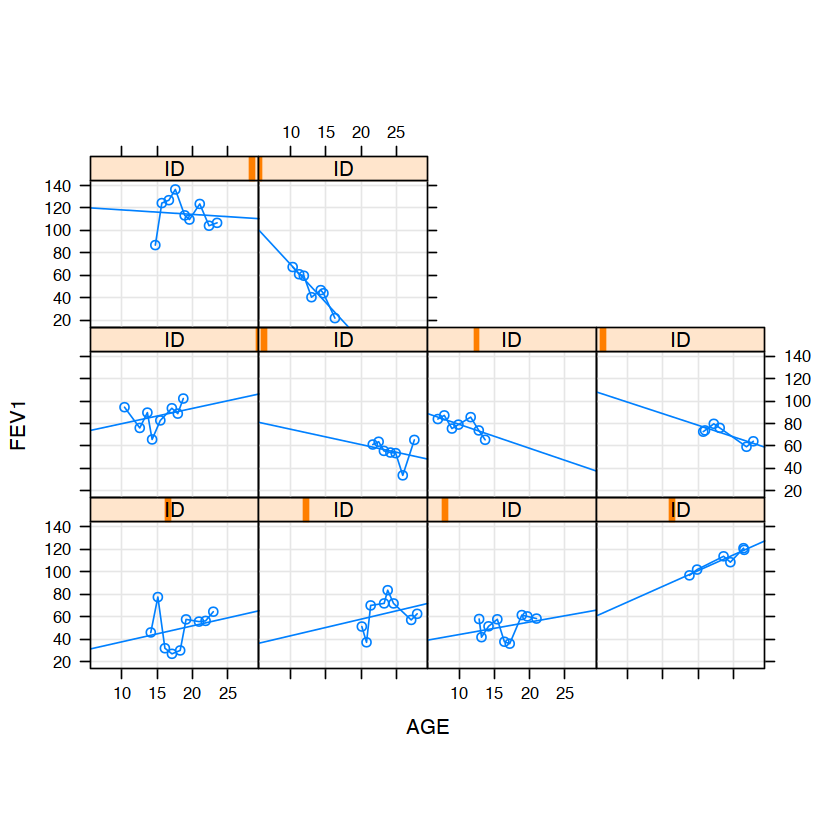

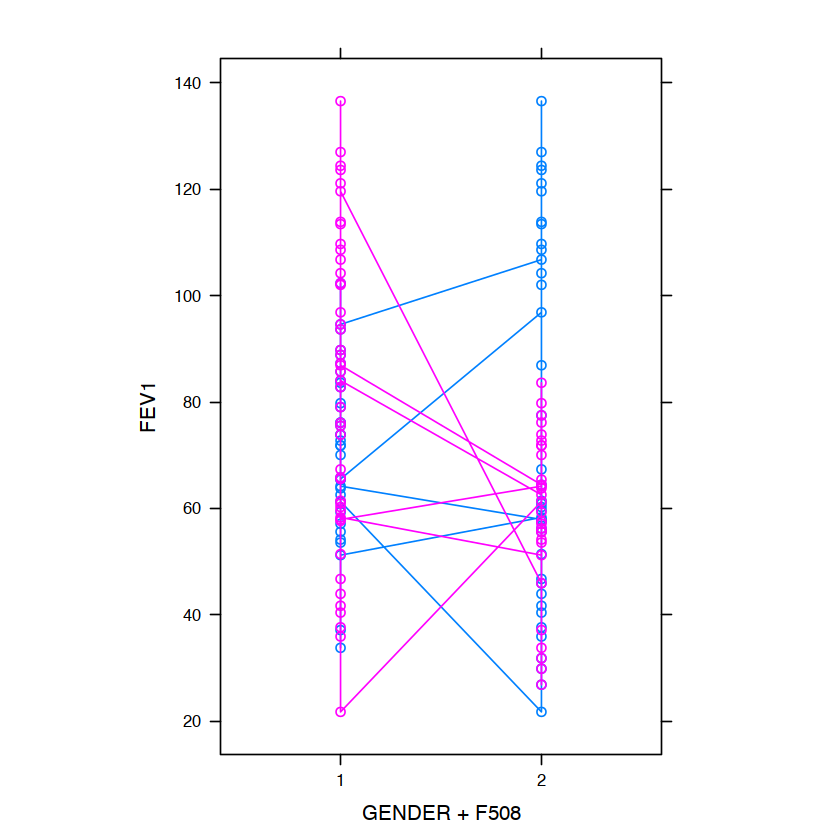

In [34]:
library(lattice)
sam_CF = as.character(sample(unique(CF$ID),10))

sam2 = CF[CF$ID %in% sam_CF,]
xyplot(FEV1 ~ AGE | ID, sam2,type = c("g","p","r","l"),
       index = function(x,y) coef(lm(y ~ x))[1],
       aspect = "xy")

xyplot(FEV1 ~ GENDER + F508, sam2,type = c("b"),
       index = function(x,y) coef(lm(y ~ x))[1],
       aspect = "xy")

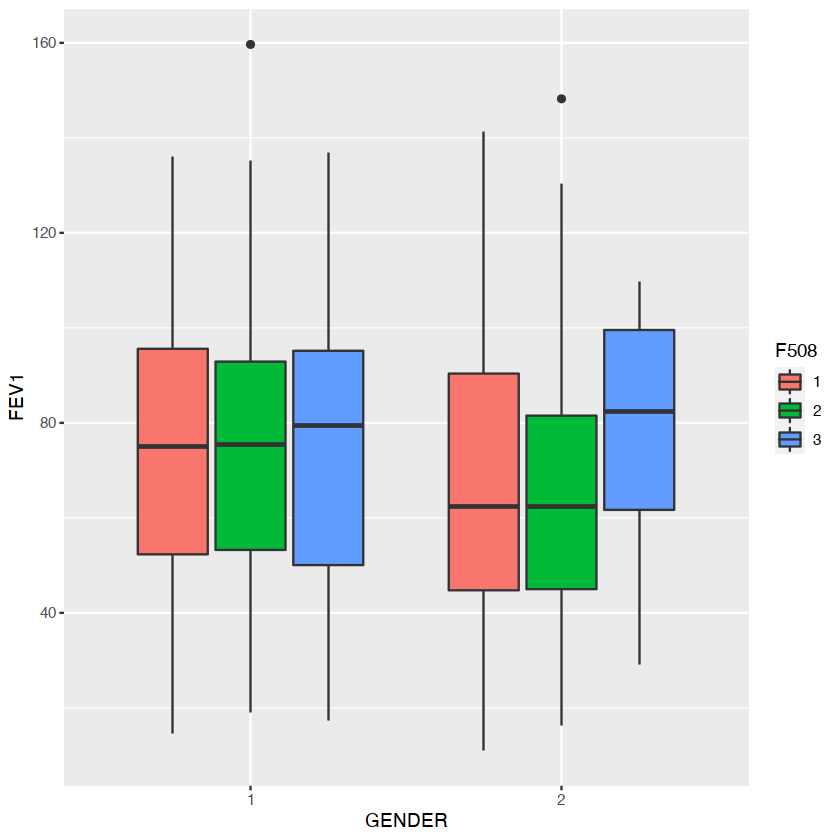

In [35]:
require(ggplot2)
ggplot(data = CF, aes(x=GENDER, y=FEV1))+
  geom_boxplot(aes(fill=F508))